## Introduction: Effect of Noise

**Experiment Overview:** This experiment analyzes how noise in the data generation process affects the relationship between smoothness and predictivity. We start by generating hidden factors from white noise, labels from a linear transformation $y = Ah$, and observations from a simple non-linear transformation $x = g(h) + \epsilon$. Then we vary the amount of noise, $\epsilon$, in the data, and analyze how the relationship between smoothness and predictivity change. For each amount of noise, we produce latent representations with different methods.

**Hypothesis:** Our hypothesis is that as we increase the amount of noise in the data generating process, the correlation between predictivity and smoothness increases. This comes from the theoretical observation that a representation being smooth is similar to being invariant to noise.

In [2]:
import numpy as np
import pandas as pd

np.random.seed(0)
H_DIMENSION = 2

# Generate Gaussian hidden factors
hidden = np.random.normal(0, 1, size=(H_DIMENSION, 1000))

# Create a dataframe to carry the data
h_variables = [f'h_{i}' for i in range(H_DIMENSION)]
data = pd.DataFrame(hidden.T, columns=h_variables)

# Generate labels from a linear combination of hidden factors
A = np.random.normal(1, 1, size=(1, H_DIMENSION))
labels = (A @ hidden).T
data['y'] = labels

data.head()

,h_0,h_1,y
0,1.764052,0.555963,-1.335929
1,0.400157,0.892474,-0.848667
2,0.978738,-0.422315,-0.220915
3,2.240893,0.104714,-1.268772
4,1.867558,0.228053,-1.157628


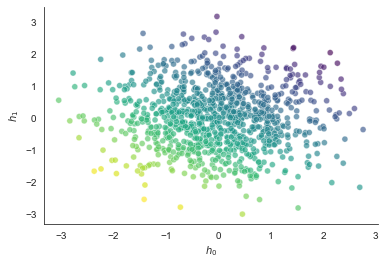

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define plotting settings
sns.set_style('white')
color_map = sns.color_palette('viridis', as_cmap=True)

# Plot distribution of hidden factors colored by labels
sns.scatterplot(data=data, x='h_0', y='h_1', hue='y', alpha=0.65,
                palette=color_map).get_legend().remove()
plt.xlabel('$h_0$'); plt.ylabel('$h_1$'); sns.despine()

plt.show()

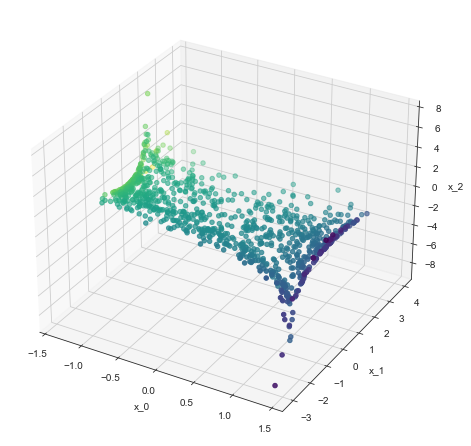

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate observations from non-linear transformations
data['x_0'] = np.tanh(data['h_0'] + data['h_1'])
data['x_1'] = np.maximum(0, data['h_0']) - data['h_1']
data['x_2'] = np.log(abs(data['h_0'])) * data['h_1']

# Normalize all observations to have mean of 0 and variance of 1
for i in range(H_DIMENSION + 1):
    data[f'x_{i}'] = (data[f'x_{i}'] - data[f'x_{i}'].mean()) / data[f'x_{i}'].std()

# Figure setup and visual features
fig = plt.figure(figsize=(7,6))
ax = Axes3D(fig)

# Plot the observations in a 3D grid colored by labels
ax.scatter(data['x_0'], data['x_1'], data['x_2'], c=data['y'], cmap=color_map)
ax.set_xlabel('x_0'); ax.set_ylabel('x_1'); ax.set_zlabel('x_2')

plt.show()

## Running the Experiment

**Steps to be taken:** We have now generated hidden factors, labels, and observations. The remaining parts of the experiment are: (i) create a systematic way of calculating smoothness and predictivity, (ii) generate corrupted observations with varying amounts of noise, and (iii) for ach of them evaluate the properties using different latent methods. After these steps we will only have to analyze the empirical results and search for trends.

**Methods used:** We selected methods that reduce the dimension of the data and are inductive. Most of them are linear, and we gave priority to methods that are easy to implement.

**Properties of latent space**: We measure 3 different properties of the latent space: smoothness, predictivity, and disentanglement. The metrics used are based on a document produced by Tomas. Importantly, calculating smoothness is the most expensive part of the process.

In [5]:
# Get latent representations for a given method
def create_latent_space(df_train, df_test, latent_method):
    mapping = latent_method(n_components=H_DIMENSION, random_state=0).fit(df_train[x_variables])
    latent = mapping.transform(df_test[x_variables])
    latent = pd.DataFrame(latent, columns=z_variables)
    latent = pd.concat([df_test, latent], axis=1)
    return latent

# Create dataframes for each method
def get_latent_spaces(df_train, df_test, latent_methods):
    latent_spaces = []
    for latent_method in latent_methods:
        latent = create_latent_space(df_train, df_test, latent_method)
        latent_spaces.append(latent)
    return latent_spaces

In [6]:
from sklearn.decomposition import FactorAnalysis, PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.model_selection import train_test_split

# List of latent methods we are using
methods = [FactorAnalysis, PCA, FastICA, LocallyLinearEmbedding]
x_variables = [f'x_{i}' for i in range(H_DIMENSION + 1)]
z_variables = [f'z_{i}' for i in range(H_DIMENSION)]

# Split the data into train and test sets
data_train, data_test = train_test_split(data, test_size=0.25, random_state=0)
data_train = data_train.reset_index(drop=True); data_test = data_test.reset_index(drop=True)

In [7]:
from representation_learning.metrics import multiple_correlation, mutual_information_gap, inverted_kruskals_stress

noise_std = [i / 100 for i in range(0, 62, 2)]
results = [[[], [], []] for i in range(len(noise_std))]

for trial, std in enumerate(noise_std):

    # Add noise to the data after creating a deep copy
    noisy_data_train = data_train.copy()
    noisy_data_test = data_test.copy()
    for i in range(H_DIMENSION + 1):
        noisy_data_train[f'x_{i}'] = noisy_data_train[f'x_{i}'] + np.random.normal(0, std, 750)
        noisy_data_test[f'x_{i}'] = noisy_data_test[f'x_{i}'] + np.random.normal(0, std, 250)

    # Obtain the individual latent spaces
    fa, pca, ica, lle = get_latent_spaces(noisy_data_train, noisy_data_test, methods)

    # Get metrics for each method
    for index, latent_space in enumerate([fa, pca, ica, lle]):
        results[trial][0].append(multiple_correlation(latent_space, 'y', z_variables))
        results[trial][1].append(inverted_kruskals_stress(latent_space, x_variables, z_variables, 0.01, silent=True))
        results[trial][2].append(mutual_information_gap(latent_space, h_variables, z_variables))

    print(f'Done std {std}')

Done std 0.0
Done std 0.02
Done std 0.04
Done std 0.06
Done std 0.08
Done std 0.1
Done std 0.12
Done std 0.14
Done std 0.16
Done std 0.18
Done std 0.2
Done std 0.22
Done std 0.24
Done std 0.26
Done std 0.28
Done std 0.3
Done std 0.32
Done std 0.34
Done std 0.36
Done std 0.38
Done std 0.4
Done std 0.42
Done std 0.44
Done std 0.46
Done std 0.48
Done std 0.5
Done std 0.52
Done std 0.54
Done std 0.56
Done std 0.58
Done std 0.6


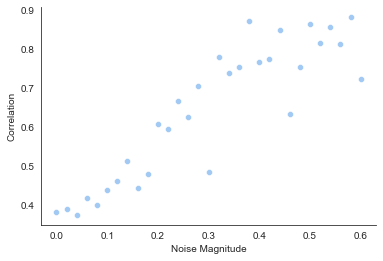

In [9]:
correlation = []
for result in results:
    correlation.append(np.corrcoef(result[0][:3], result[1][:3])[0, 1])

sns.set_palette('pastel')
sns.scatterplot(x=noise_std, y=correlation)
sns.despine()
plt.xlabel('Noise Magnitude'); plt.ylabel('Correlation')
plt.savefig('results/noise_vs_correlation.png', dpi=200)
plt.show()